In [47]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf 
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pandas as pd
from sklearn import decomposition
from keras.models import Model

In [6]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [7]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['seg_train/seg_train','./seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [8]:
(train_images, train_labels), (test_images, test_labels) = load_data()


Loading seg_train/seg_train


100%|██████████| 2382/2382 [00:01<00:00, 1771.75it/s]


Loading ./seg_test/seg_test


100%|██████████| 501/501 [00:00<00:00, 965.95it/s] 


In [9]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [10]:
n_train = train_images.shape
n_test = test_images.shape

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: (14034, 150, 150, 3)
Number of testing examples: (3000, 150, 150, 3)
Each image is of size: (150, 150)


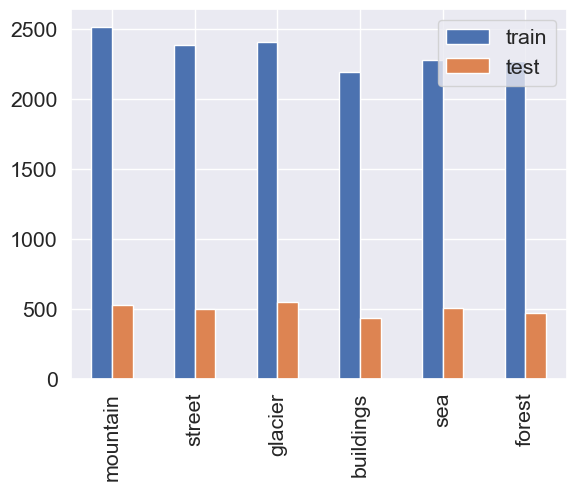

In [60]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

In [11]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [62]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [63]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [64]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 109s 1s/step - loss: 1.3199 - accuracy: 0.5002 - val_loss: 0.8872 - val_accuracy: 0.6605
Epoch 2/20
88/88 [==============================] - 108s 1s/step - loss: 0.7518 - accuracy: 0.7193 - val_loss: 0.7358 - val_accuracy: 0.7399
Epoch 3/20
88/88 [==============================] - 109s 1s/step - loss: 0.5746 - accuracy: 0.7979 - val_loss: 0.7445 - val_accuracy: 0.7296
Epoch 4/20
88/88 [==============================] - 110s 1s/step - loss: 0.4229 - accuracy: 0.8529 - val_loss: 0.7867 - val_accuracy: 0.7253
Epoch 5/20
88/88 [==============================] - 109s 1s/step - loss: 0.3221 - accuracy: 0.8921 - val_loss: 0.9184 - val_accuracy: 0.6983
Epoch 6/20
88/88 [==============================] - 113s 1s/step - loss: 0.2160 - accuracy: 0.9322 - val_loss: 0.8260 - val_accuracy: 0.7510
Epoch 7/20
88/88 [==============================] - 108s 1s/step - loss: 0.1357 - accuracy: 0.9621 - val_loss: 0.9169 - val_accuracy: 0.7300
Epoch 8/20
88

In [67]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

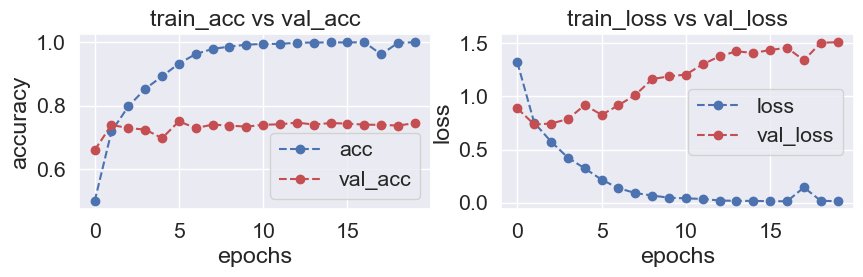

In [68]:
plot_accuracy_loss(history)

In [69]:
test_loss = model.evaluate(test_images, test_labels)


94/94 [==============================] - 7s 71ms/step - loss: 1.4821 - accuracy: 0.7530


In [79]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [76]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

In [77]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability


94/94 [==============================] - 7s 71ms/step


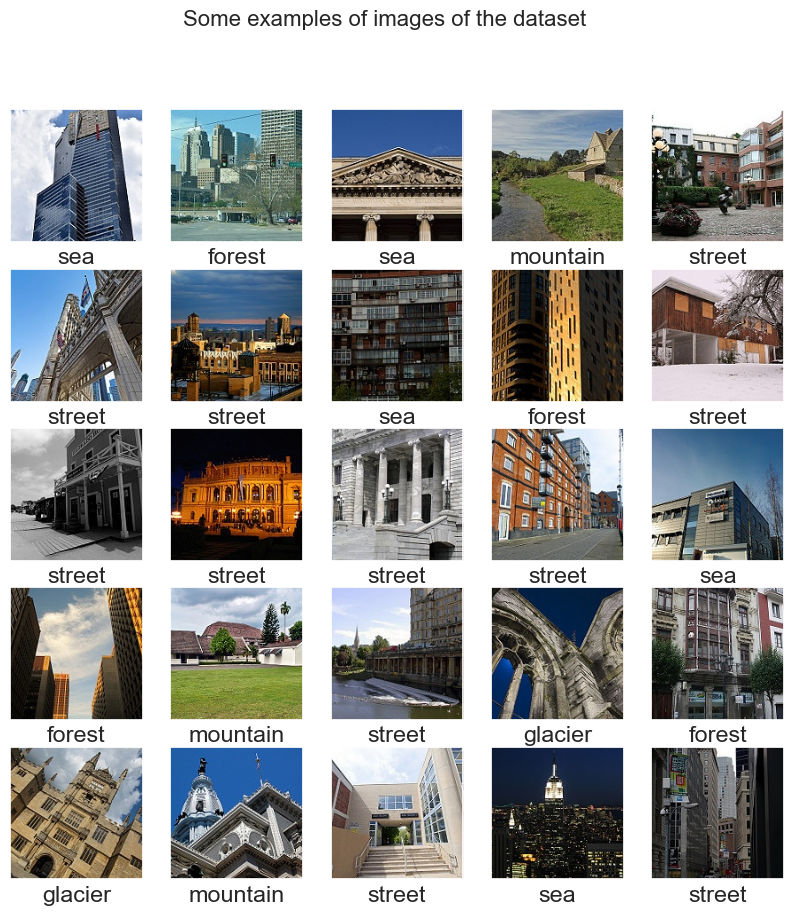

In [80]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

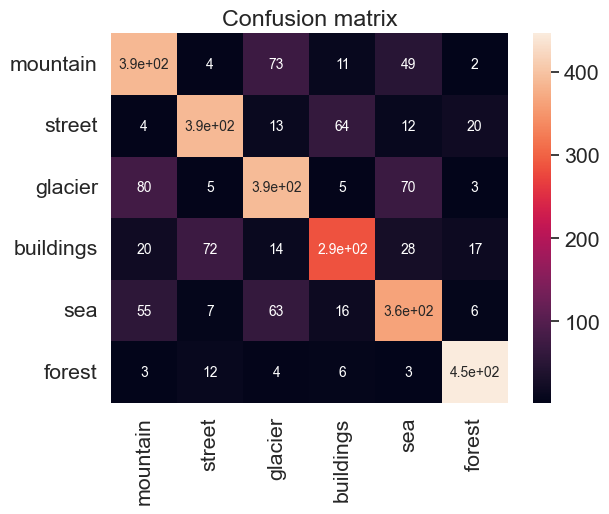

In [81]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [12]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

In [14]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

94/94 [==============================] - 148s 2s/step


In [15]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [89]:
pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # Représentation des individus dans les nouveaux axe
C1 = C[:,0]
C2 = C[:,1]

In [93]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [94]:
history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 1s 7ms/step - loss: 0.5371 - accuracy: 0.8010 - val_loss: 0.3672 - val_accuracy: 0.8732
Epoch 2/15
88/88 [==============================] - 1s 6ms/step - loss: 0.2978 - accuracy: 0.8945 - val_loss: 0.3635 - val_accuracy: 0.8682
Epoch 3/15
88/88 [==============================] - 0s 6ms/step - loss: 0.2378 - accuracy: 0.9171 - val_loss: 0.3613 - val_accuracy: 0.8707
Epoch 4/15
88/88 [==============================] - 1s 6ms/step - loss: 0.1958 - accuracy: 0.9297 - val_loss: 0.3340 - val_accuracy: 0.8878
Epoch 5/15
88/88 [==============================] - 0s 6ms/step - loss: 0.1668 - accuracy: 0.9425 - val_loss: 0.3872 - val_accuracy: 0.8675
Epoch 6/15
88/88 [==============================] - 0s 6ms/step - loss: 0.1438 - accuracy: 0.9531 - val_loss: 0.3476 - val_accuracy: 0.8835
Epoch 7/15
88/88 [==============================] - 0s 6ms/step - loss: 0.1170 - accuracy: 0.9644 - val_loss: 0.3545 - val_accuracy: 0.8831
Epoch 8/15
88/88 [==

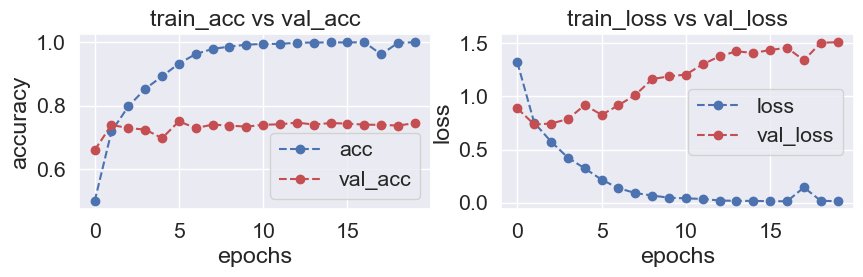

In [95]:
plot_accuracy_loss(history)

In [96]:
test_loss = model2.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 1ms/step - loss: 0.4480 - accuracy: 0.8767


In [22]:
np.random.seed(seed=42)
n_estimators = 12
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

In [16]:
model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [17]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

94/94 [==============================] - 143s 2s/step


In [23]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

models = list()
random = np.random.randint(50, 100, size = n_estimators)

input_shape = model2.layers[-4].get_input_shape_at(0) 
layer_input = Input(shape = (9, 9, 512)) 
for i in range (n_estimators):
    x = layer_input
    for layer in model2.layers[-4::1]:
        x = layer(x)
        
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(random[i],activation='relu')(x)
    x = Dense(6,activation='softmax')(x)

    new_model = Model(layer_input, x)
    new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    models.append(new_model)

In [24]:
histories = []
for i in range(n_estimators):
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.15))

Epoch 1/10
75/75 [==============================] - 166s 2s/step - loss: 0.8051 - accuracy: 0.6789 - val_loss: 0.4144 - val_accuracy: 0.8445
Epoch 2/10
75/75 [==============================] - 170s 2s/step - loss: 0.3480 - accuracy: 0.8739 - val_loss: 0.2887 - val_accuracy: 0.8997
Epoch 3/10
75/75 [==============================] - 170s 2s/step - loss: 0.2240 - accuracy: 0.9223 - val_loss: 0.2423 - val_accuracy: 0.9181
Epoch 4/10
75/75 [==============================] - 168s 2s/step - loss: 0.1679 - accuracy: 0.9399 - val_loss: 0.2109 - val_accuracy: 0.9282
Epoch 5/10
75/75 [==============================] - 168s 2s/step - loss: 0.1196 - accuracy: 0.9576 - val_loss: 0.2511 - val_accuracy: 0.9294
Epoch 6/10
75/75 [==============================] - 170s 2s/step - loss: 0.1231 - accuracy: 0.9601 - val_loss: 0.2528 - val_accuracy: 0.9300
Epoch 7/10
75/75 [==============================] - 168s 2s/step - loss: 0.0744 - accuracy: 0.9752 - val_loss: 0.2689 - val_accuracy: 0.9389
Epoch 8/10
75

In [27]:
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.9013333333333333


In [31]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

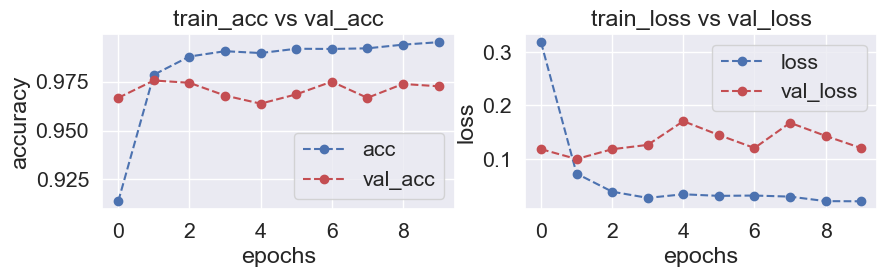

In [50]:
plot_accuracy_loss(histories[3])

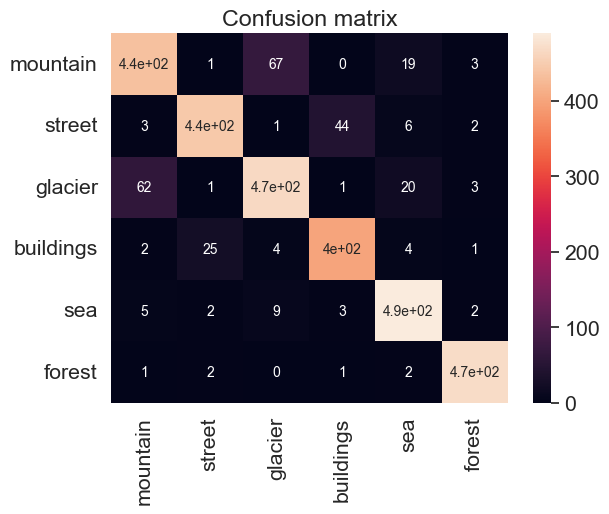

In [46]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()